# Bayesian Linear Regression with PyMC

## Objective
Implement a Bayesian linear regression model using **PyMC** and analyze posterior uncertainty.

## What this notebook demonstrates
- Prior specification for regression coefficients and noise variance  
- Posterior inference via MCMC sampling  
- Convergence diagnostics (e.g., R-hat / ESS via ArviZ)  
- Posterior predictive checks and uncertainty-aware predictions  

## Notes
This notebook was developed as part of learning computational Bayesian inference (inspired by examples from *Bayesian Analysis with Python*), with additional cleanup and commentary for clarity and reproducibility.


In [ ]:
!pip install preliz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.4/519.4 kB 7.4 MB/s eta 0:00:00


## Reproducibility
If results vary run-to-run, set a random seed for NumPy/PyMC and consider increasing the number of draws/tuning steps.


In [ ]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import preliz as pz
import xarray as xr
from scipy.interpolate import PchipInterpolator
from scipy.stats import linregress

## Simple linear regression

<Axes: xlabel='temperature', ylabel='rented'>

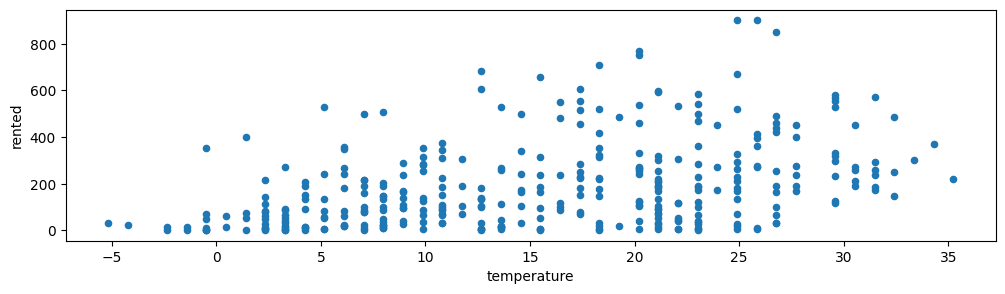

In [ ]:
bikes = pd.read_csv("bikes.csv")
bikes.plot(x="temperature", y="rented", figsize=(12, 3), kind="scatter")

In [ ]:
bikes.head()

,rented,hour,temperature,humidity,windspeed,weekday
0,16,0,3.28,0.81,0.0000,6
1,3,5,-0.48,0.47,0.2836,1
2,115,9,2.34,0.37,0.3284,3
3,73,13,1.40,0.37,0.2836,5
4,82,15,2.34,0.35,0.3582,0


In [ ]:
#Modelling the relation between temperature and number of bikes rented
with pm.Model() as model_lb:
    α = pm.Normal("α", mu=0, sigma=100)
    β = pm.Normal("β", mu=0, sigma=10)
    σ = pm.HalfCauchy("σ", 10)
    μ = pm.Deterministic("μ", α + β * bikes.temperature)
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=bikes.rented)
    idata_lb = pm.sample(random_seed=123)

Output()

array([<Axes: title={'center': 'α'}>, <Axes: title={'center': 'β'}>,
       <Axes: title={'center': 'σ'}>], dtype=object)

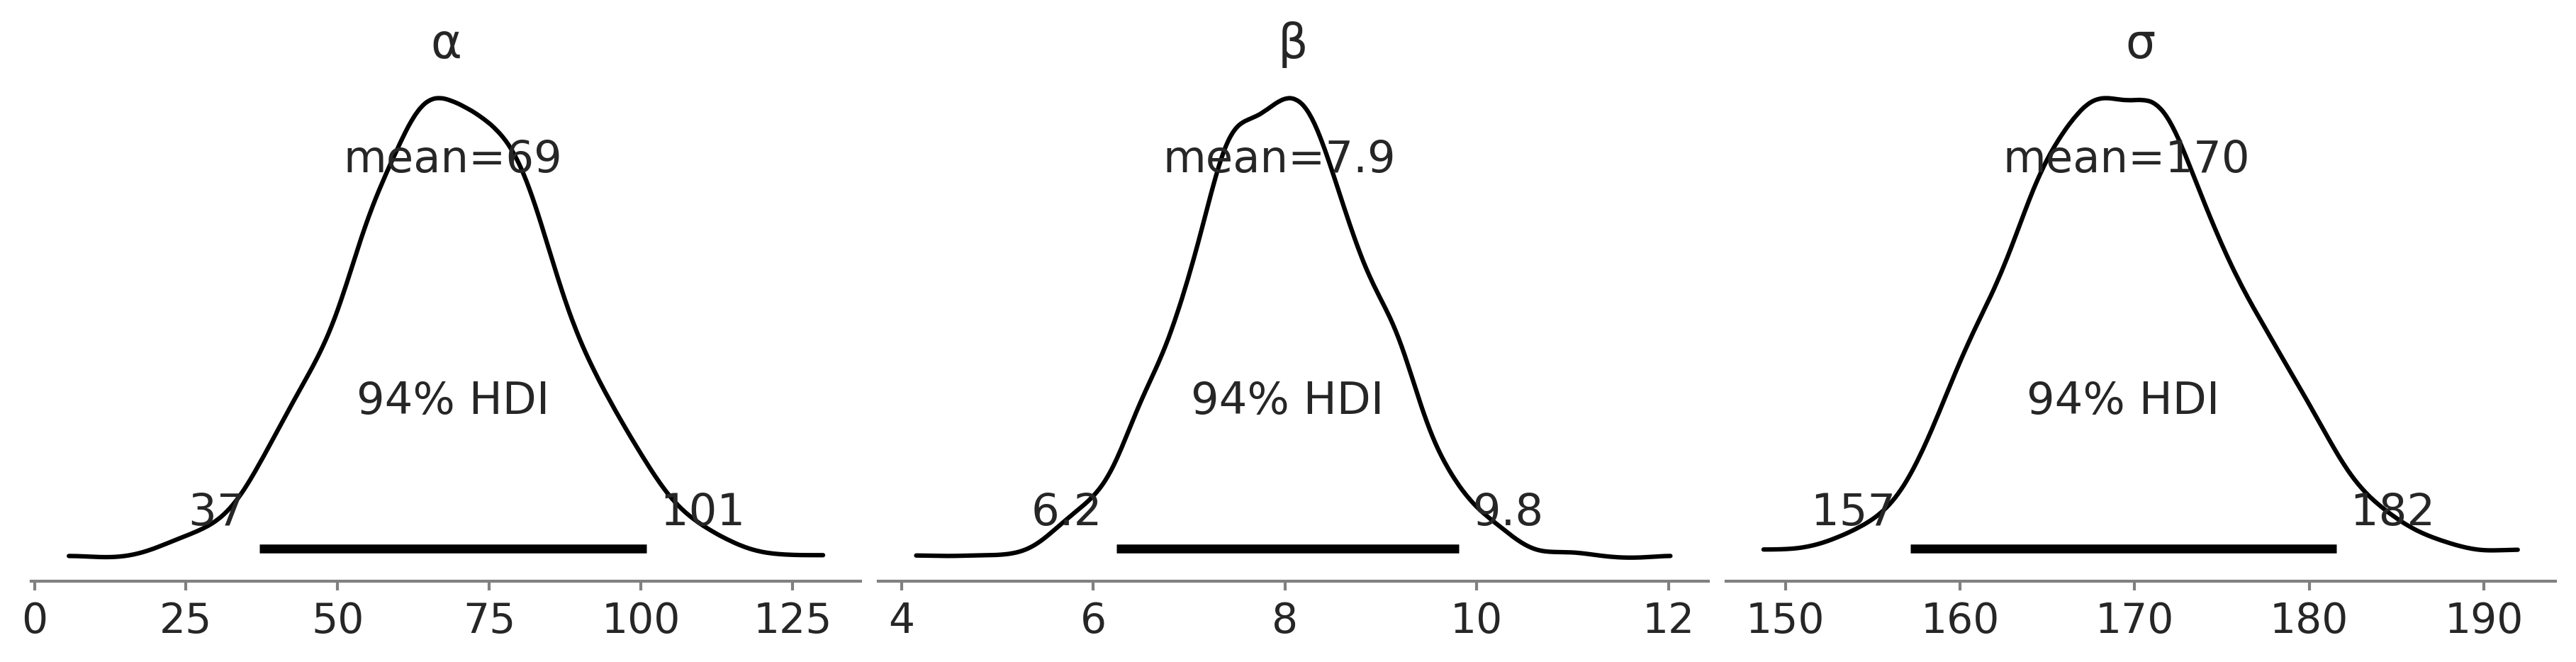

In [ ]:
#Plotting the parameters expect for global mean
az.plot_posterior(idata_lb, var_names=["~μ"], figsize=(12, 3))

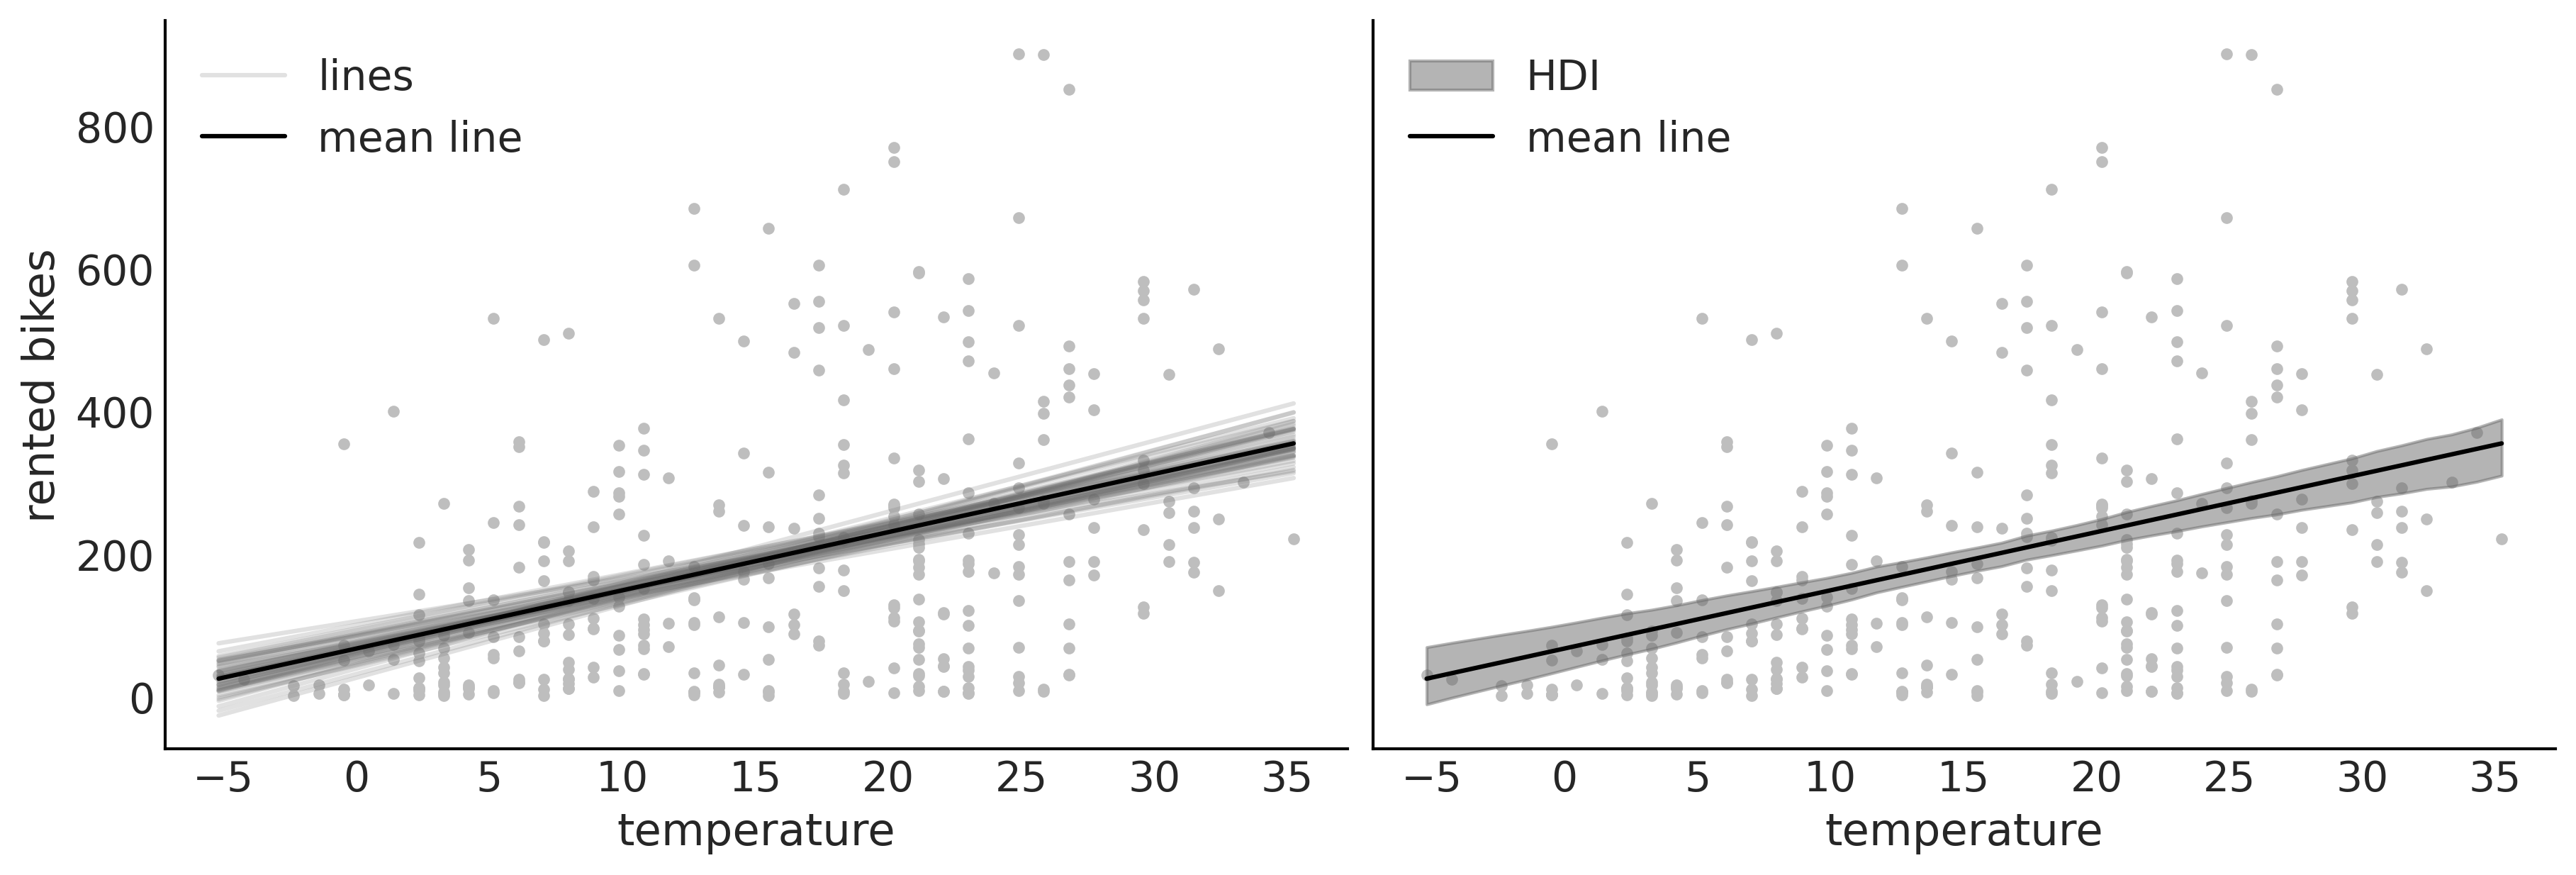

In [ ]:
#Representing uncertainities
#extract the 50 samples from the entire posterior data(chains & draws) and storing in posterior variable
posterior = az.extract(idata_lb, num_samples=50)
#creating an array of temperatures ranging from lowest to highest in the data
x_plot = xr.DataArray(
    np.linspace(bikes.temperature.min(), bikes.temperature.max(), 50), dims="plot_id"
)
#equation of line considering mean alpha and mean beta
mean_line = posterior["α"].mean() + posterior["β"].mean() * x_plot
#equations for lines sampling alpha and beta from the posteriors
lines = posterior["α"] + posterior["β"] * x_plot
#Adding HDI interval to the plot
hdi_lines = az.hdi(idata_lb.posterior["μ"])


fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
#Adding list plot of (temperature, rented) values
axes[0].plot(bikes.temperature, bikes.rented, "C2.", zorder=-3)
#making plot of lines
lines_ = axes[0].plot(x_plot, lines.T, c="C1", alpha=0.2, label="lines")
plt.setp(lines_[1:], label="_")
#making plot of mean line
axes[0].plot(x_plot, mean_line, c="C0", label="mean line")
axes[0].set_xlabel("temperature")
axes[0].set_ylabel("rented bikes")
axes[0].legend()

#For right side figure:
#Adding list plot of (temperature, rented) values
axes[1].plot(bikes.temperature, bikes.rented, "C2.", zorder=-3)
#inded of temperatures in ascending order
idx = np.argsort(bikes.temperature.values)
#plot of shaded region
axes[1].fill_between(
    bikes.temperature[idx],
    hdi_lines["μ"][:, 0][idx],
    hdi_lines["μ"][:, 1][idx],
    color="C1",
    label="HDI",
    alpha=0.5,
)
#adding mean line to plot
axes[1].plot(x_plot, mean_line, c="C0", label="mean line")
axes[1].set_xlabel("temperature")
axes[1].legend()

In [ ]:
#To do the predictions, use the posterior predictive distrbution
pm.sample_posterior_predictive(idata_lb, model=model_lb, extend_inferencedata=True, random_seed=123)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

Text(0, 0.5, 'rented bikes')

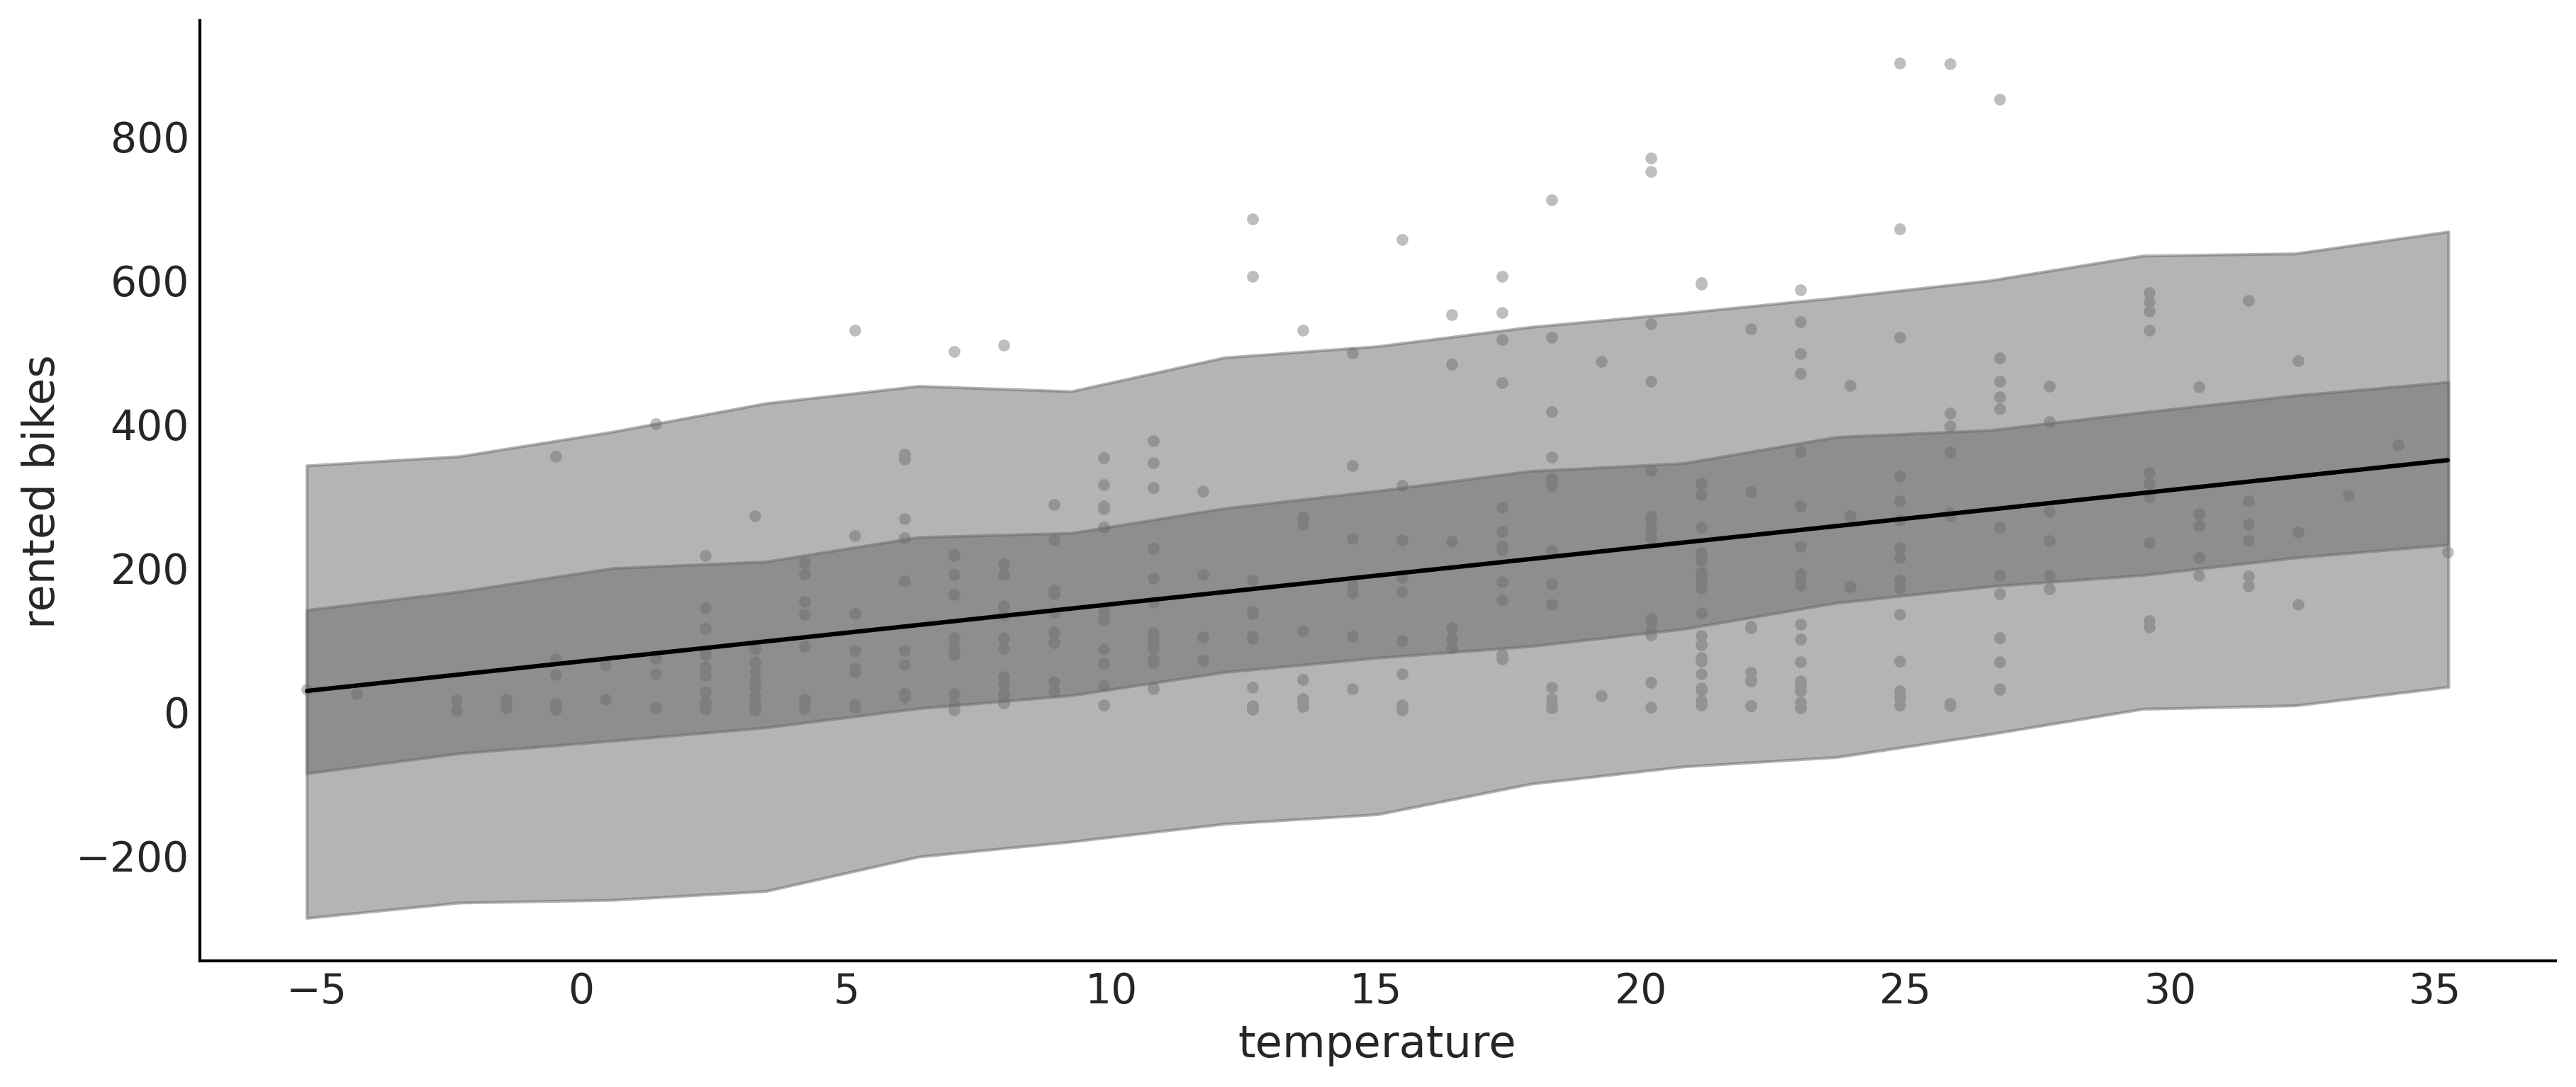

In [ ]:
#Plotting posterior predictive data
#mean of post pred dist
mean_line = idata_lb.posterior["μ"].mean(("chain", "draw"))
temperatures = np.random.normal(bikes.temperature.values, 0.01)
idx = np.argsort(temperatures)
x = np.linspace(temperatures.min(), temperatures.max(), 15)
y_pred_q = idata_lb.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
y_hat_bounds = iter(
    [
        PchipInterpolator(temperatures[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)

_, ax = plt.subplots(figsize=(12, 5))
ax.plot(bikes.temperature, bikes.rented, "C2.", zorder=-3)
ax.plot(bikes.temperature[idx], mean_line[idx], c="C0")

for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)


ax.set_xlabel("temperature")
ax.set_ylabel("rented bikes")

## Counting Bikes

In [ ]:
#Using a discrete distribution instead of a continuous one
#Also, using GLM instead of a simple linear model
with pm.Model() as model_neg:
    α = pm.Normal("α", mu=0, sigma=1)
    β = pm.Normal("β", mu=0, sigma=10)
    σ = pm.HalfNormal("σ", 10)
    μ = pm.Deterministic("μ", pm.math.exp(α + β * bikes.temperature))
    y_pred = pm.NegativeBinomial("y_pred", mu=μ, alpha=σ, observed=bikes.rented)
    idata_neg = pm.sample(random_seed=123)
    idata_neg.extend(pm.sample_posterior_predictive(idata_neg, random_seed=123))

Output()

Output()

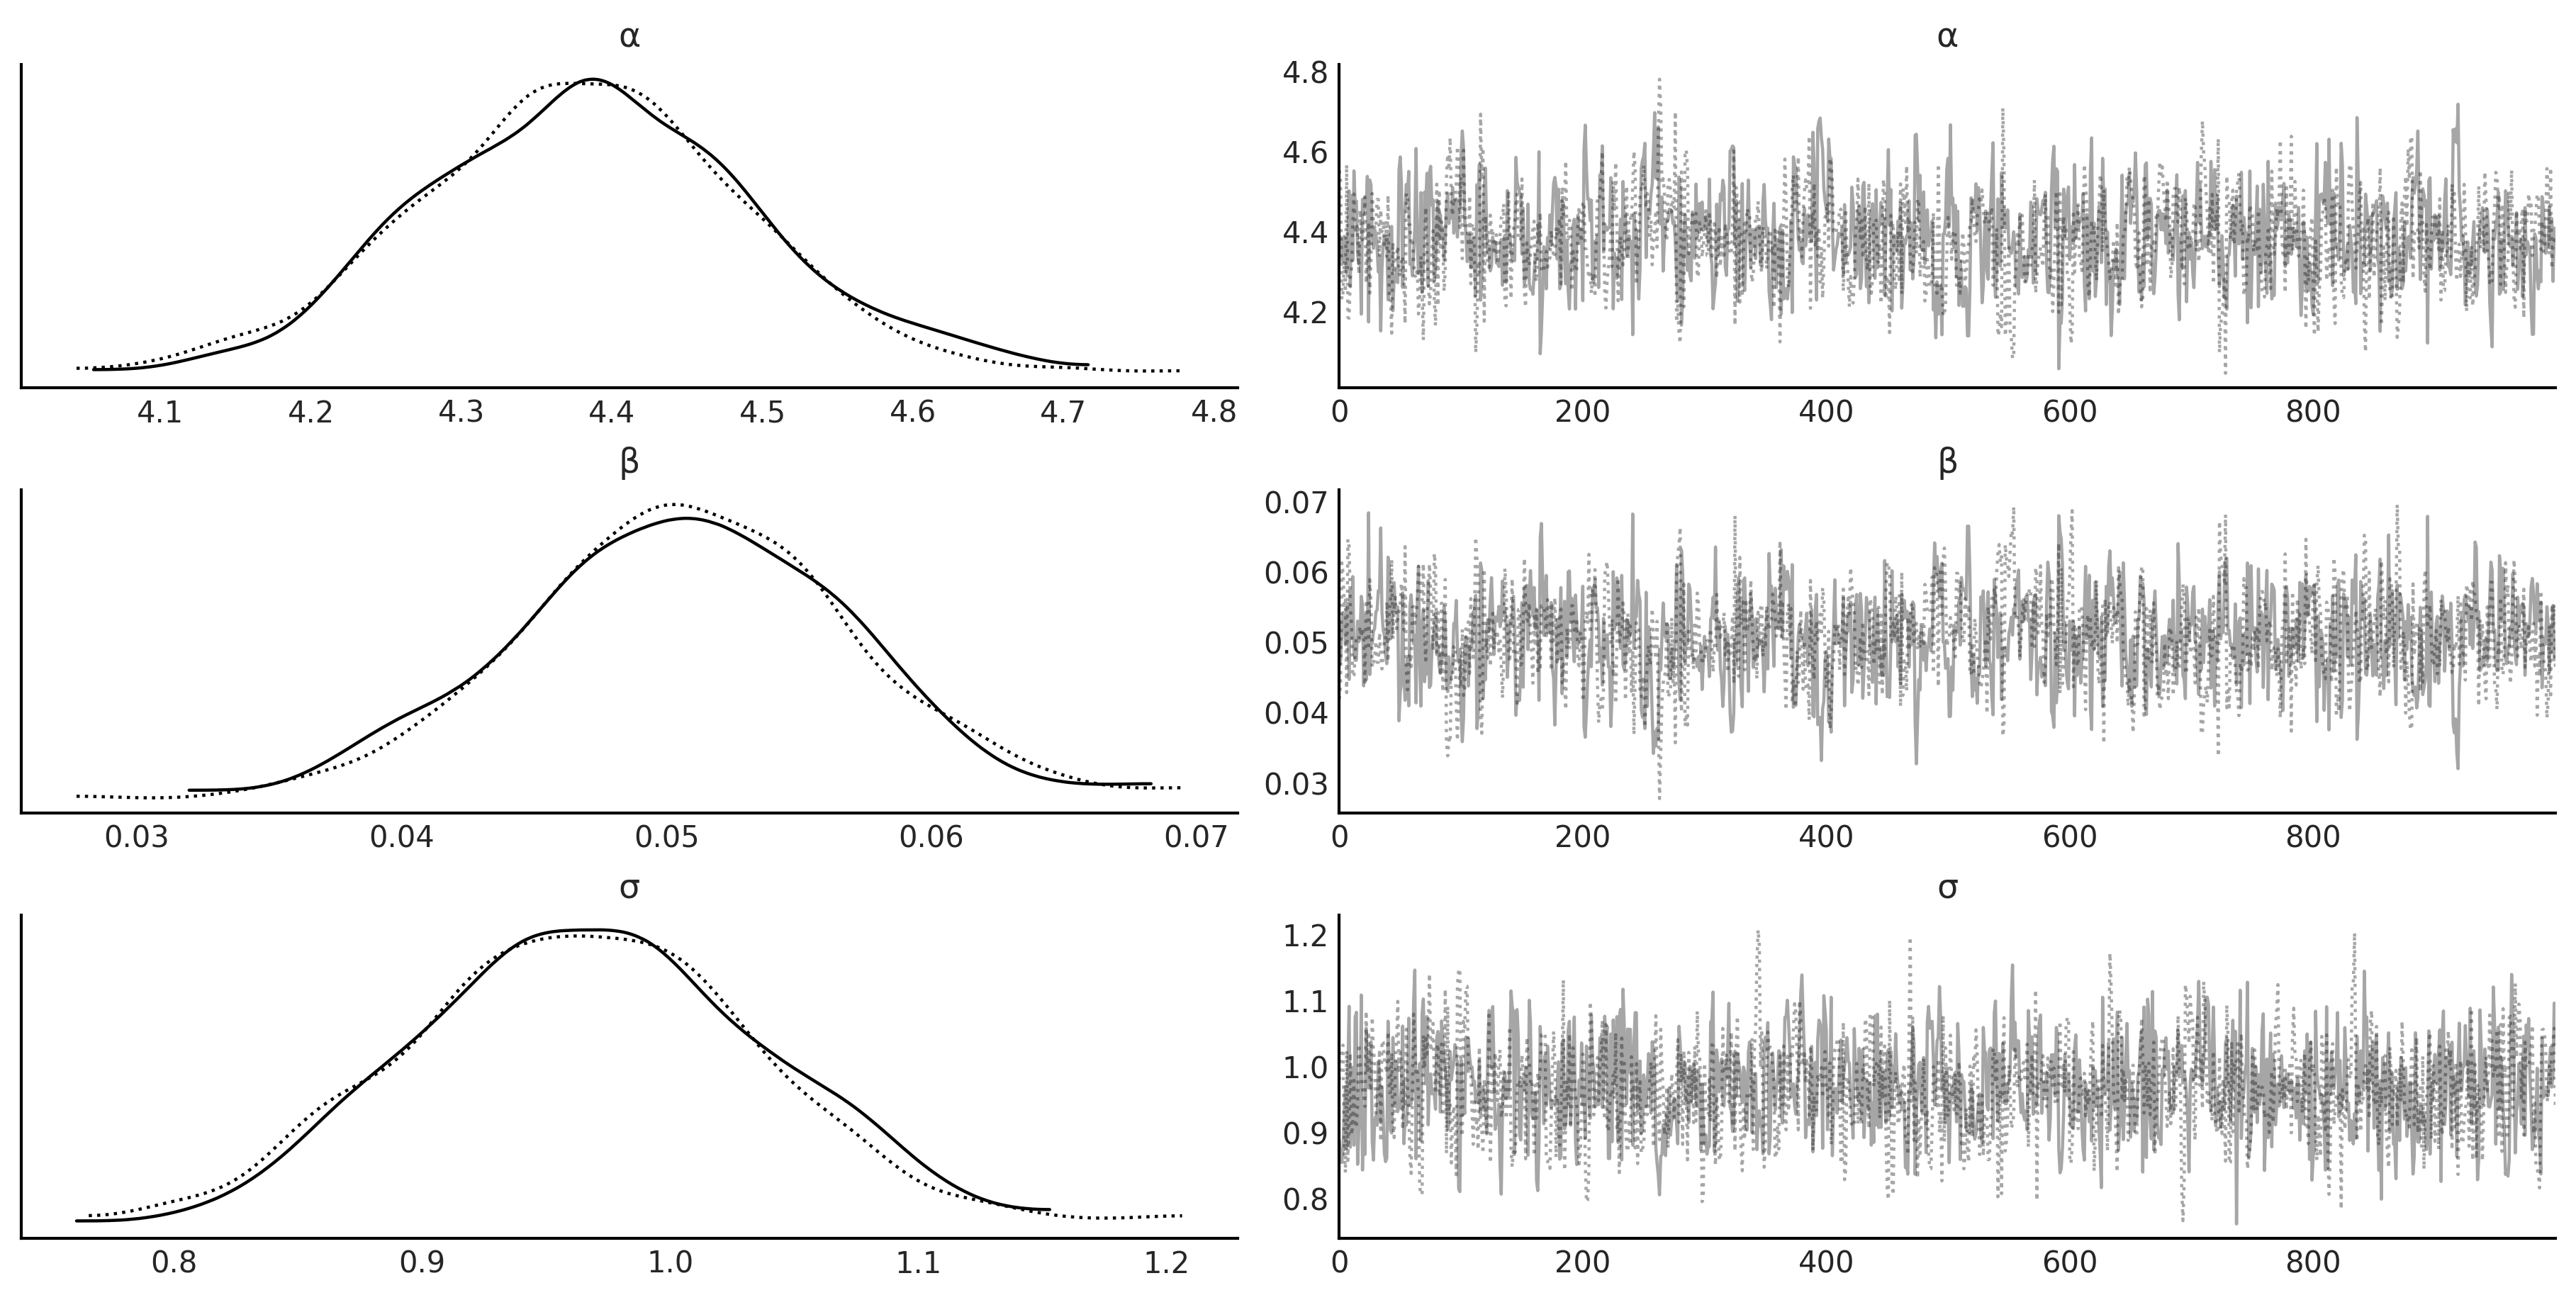

In [ ]:
az.plot_trace(idata_neg, var_names=["~μ"]);

Text(0, 0.5, 'rented bikes')

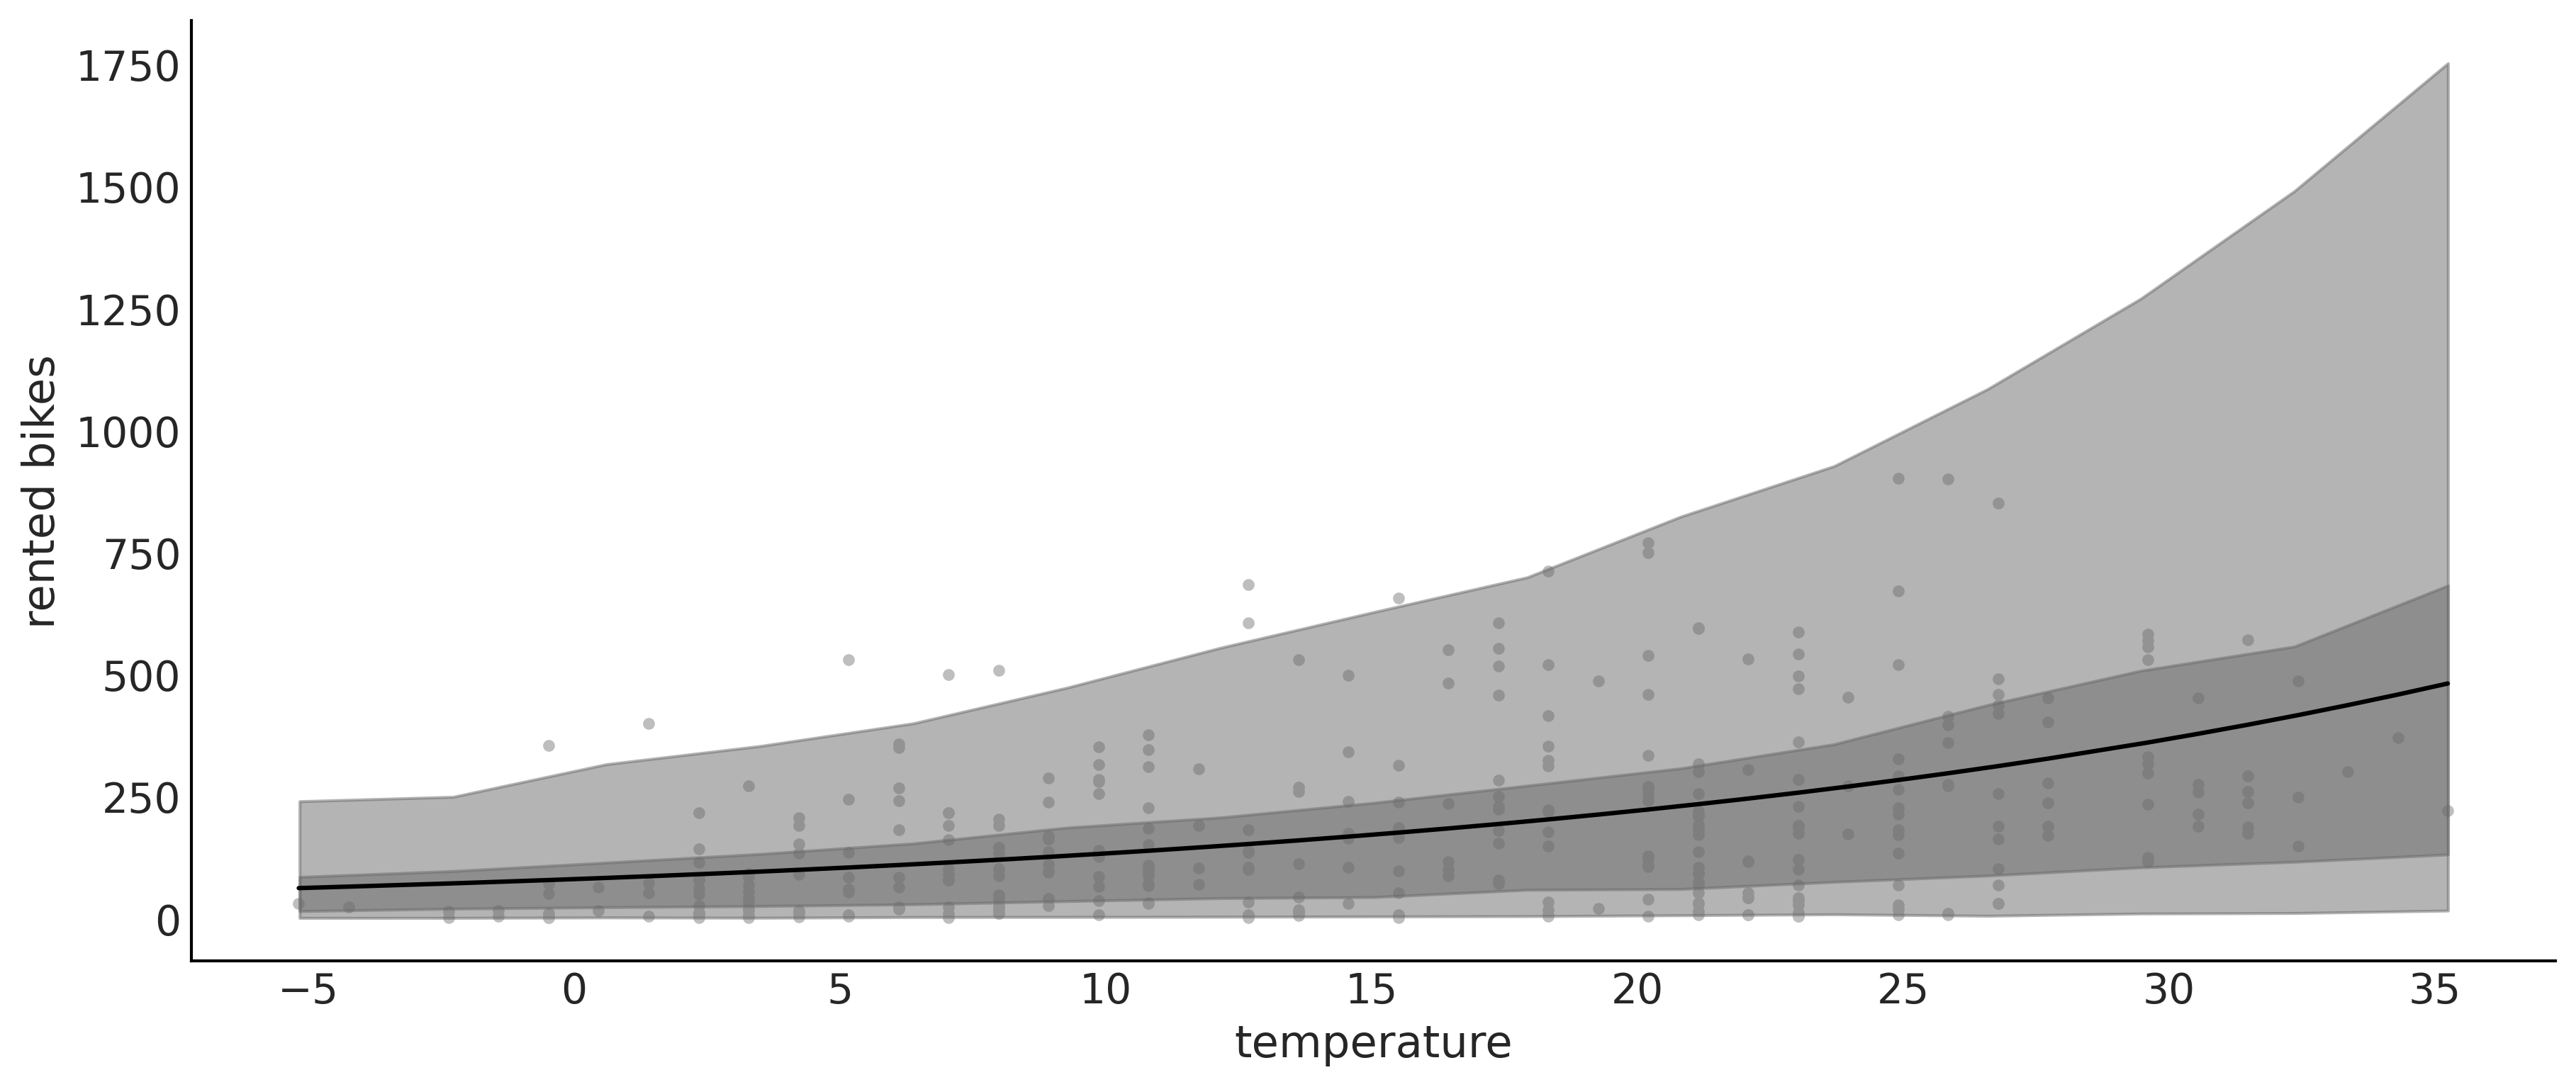

In [ ]:
#Plotting posterior predictive distributions
mean_line = idata_neg.posterior["μ"].mean(("chain", "draw"))
temperatures = np.random.normal(bikes.temperature.values, 0.01)
idx = np.argsort(temperatures)
x = np.linspace(temperatures.min(), temperatures.max(), 15)
y_pred_q = idata_neg.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
y_hat_bounds = iter(
    [
        PchipInterpolator(temperatures[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)

_, ax = plt.subplots(figsize=(12, 5))
ax.plot(bikes.temperature, bikes.rented, "C2.", zorder=-3)
ax.plot(bikes.temperature[idx], mean_line[idx], c="C0")

for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)

ax.set_xlabel("temperature")
ax.set_ylabel("rented bikes")

Text(0.5, 1.0, 'NegativeBinomial')

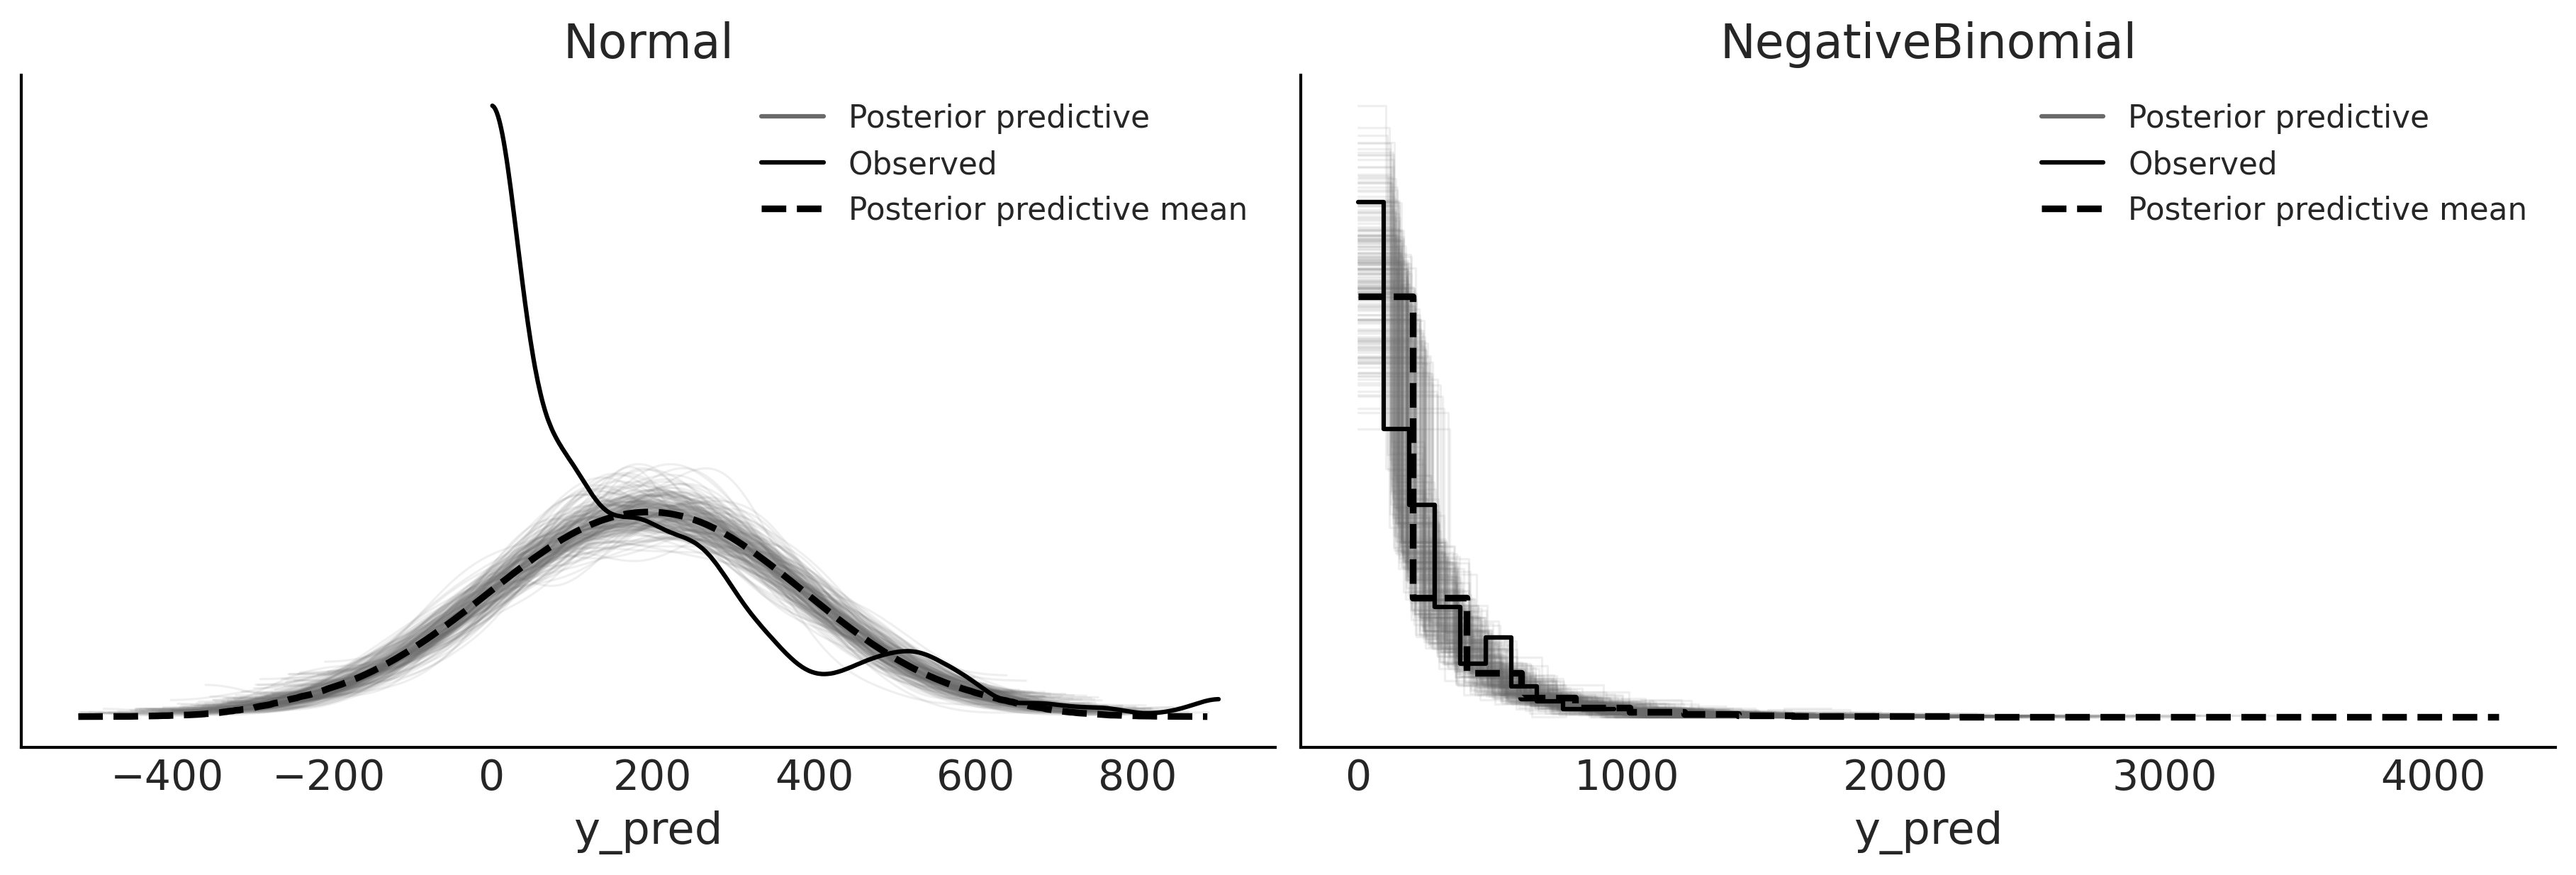

In [ ]:
#Plotting posterior predictive distributions of number of bikes rented for both models
_, ax = plt.subplots(1, 2, figsize=(12, 4))
az.plot_ppc(
    idata_lb,
    num_pp_samples=200,
    alpha=0.1,
    colors=["C1", "C0", "C0"],
    ax=ax[0],
    mean=True,
)
az.plot_ppc(
    idata_neg,
    num_pp_samples=200,
    alpha=0.1,
    colors=["C1", "C0", "C0"],
    ax=ax[1],
    mean=True,
)
ax[0].set_title("Normal")
ax[1].set_title("NegativeBinomial")

## Robust Regression

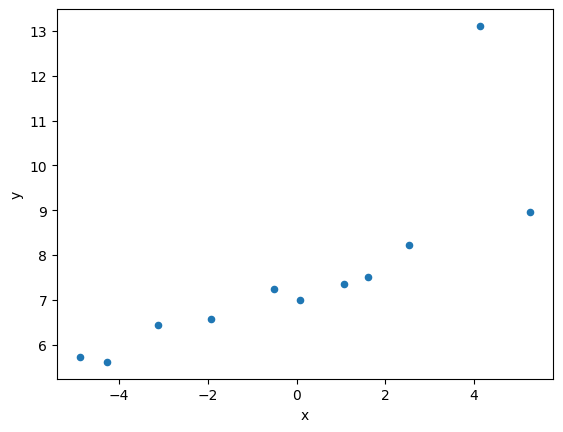

In [ ]:
ans = pd.read_csv("anscombe_3.csv")
ans.plot("x", "y", kind="scatter");

In [ ]:
#Robust Regression Model
with pm.Model() as model_t:
    α = pm.Normal("α", mu=ans.y.mean(), sigma=1)
    β = pm.Normal("β", mu=0, sigma=1)
    σ = pm.HalfNormal("σ", 5)
    ν_ = pm.Exponential("ν_", 1 / 29)
    ν = pm.Deterministic("ν", ν_ + 1)
    μ = pm.Deterministic("μ", α + β * ans.x)
    _ = pm.StudentT("y_pred", mu=μ, sigma=σ, nu=ν, observed=ans.y)

    idata_t = pm.sample(2000, random_seed=4951)

Output()

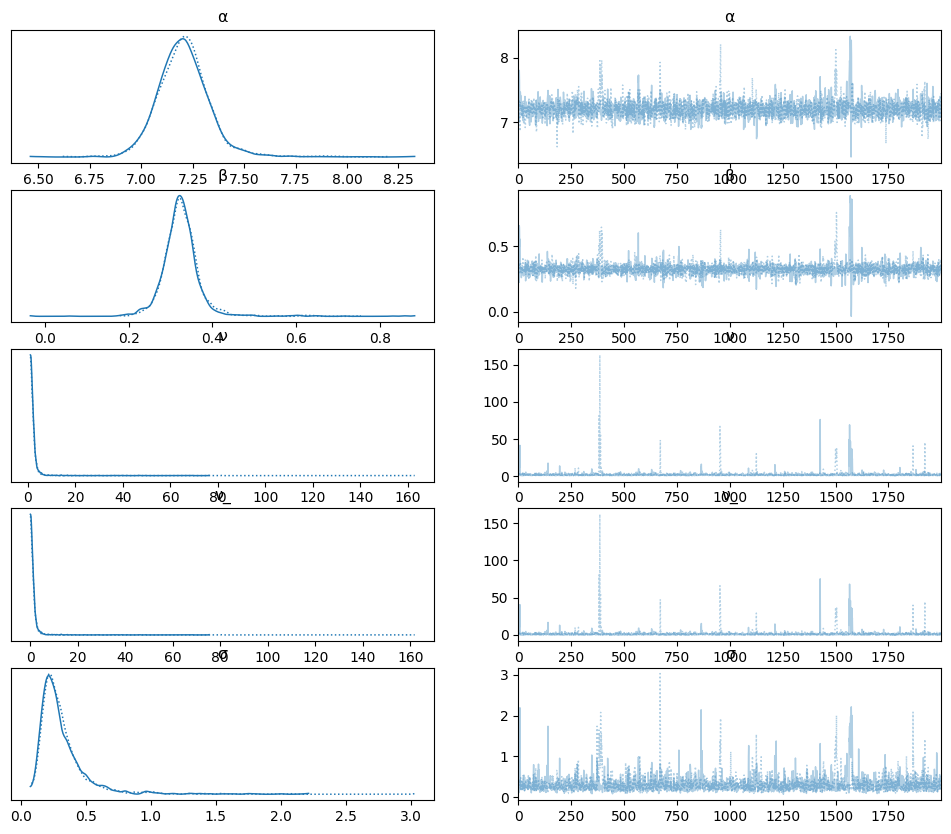

In [ ]:
az.plot_trace(idata_t, var_names=["~μ"]);

/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


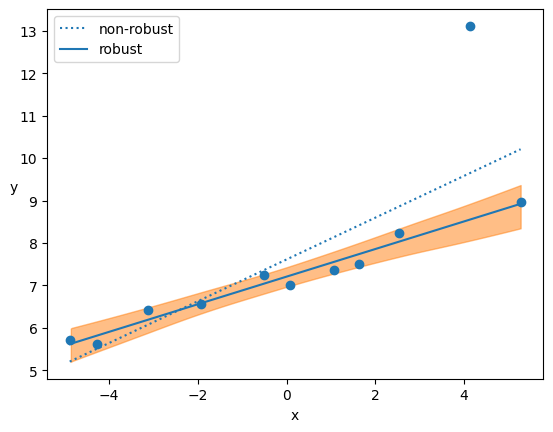

In [ ]:
#Comparing Robust vs non-robust regression models
#Non-robust linear regression using a known function in python
beta_c, alpha_c, *_ = linregress(ans.x, ans.y)

#Plots
_, ax = plt.subplots()
#Plotting non-robust line
ax.plot(ans.x, (alpha_c + beta_c * ans.x), "C0:", label="non-robust")
#scatter plot of data
ax.plot(ans.x, ans.y, "C0o")
#Finding mean of alpha and beta (intercept and slope)
alpha_m = idata_t.posterior["α"].mean(("chain", "draw"))
beta_m = idata_t.posterior["β"].mean(("chain", "draw"))
#divisions in x-axis
x_plot = xr.DataArray(np.linspace(ans.x.min(), ans.x.max(), 50), dims="plot_id")
#plotting robust line
ax.plot(x_plot, alpha_m + beta_m * x_plot, c="C0", label="robust")
#plotting HDI  interval as well
az.plot_hdi(ans.x, az.hdi(idata_t.posterior["μ"])["μ"].T, ax=ax)
ax.set_xlabel("x")
ax.set_ylabel("y", rotation=0)
ax.legend(loc=2)

In [ ]:
#Summary of the variables
az.summary(idata_t, var_names=["α", "β", "σ", "ν"], round_to=2, kind="stats")

,mean,sd,hdi_3%,hdi_97%
α,7.21,0.13,6.97,7.43
β,0.33,0.05,0.24,0.40
σ,0.32,0.21,0.09,0.61
ν,2.46,4.58,1.00,4.13


Output()

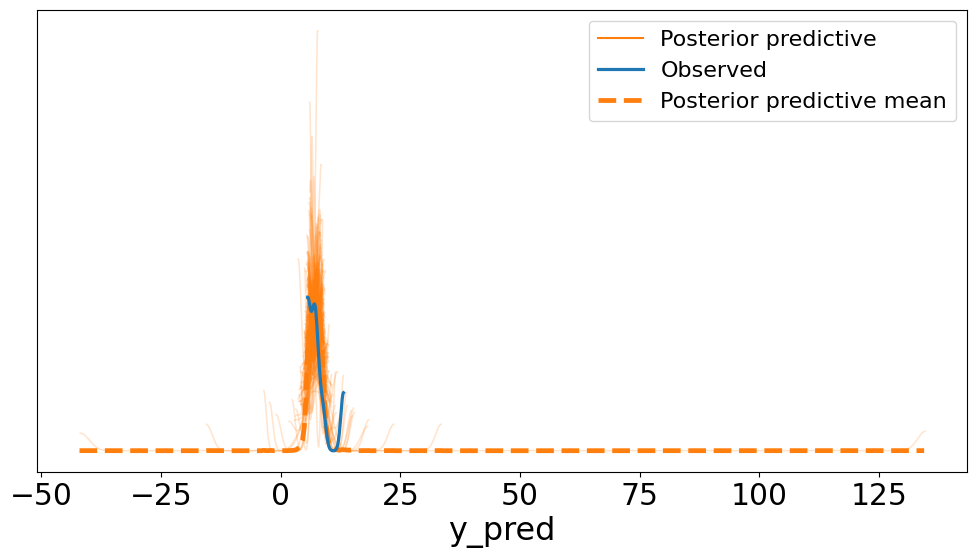

In [ ]:
#Post pred checks
pm.sample_posterior_predictive(idata_t, model=model_t, random_seed=2, extend_inferencedata=True)
ax = az.plot_ppc(idata_t, num_pp_samples=200, figsize=(12, 6), colors=["C1", "C0", "C1"])

## Logistic regression

Text(0, 0.5, 'logistic(z)')

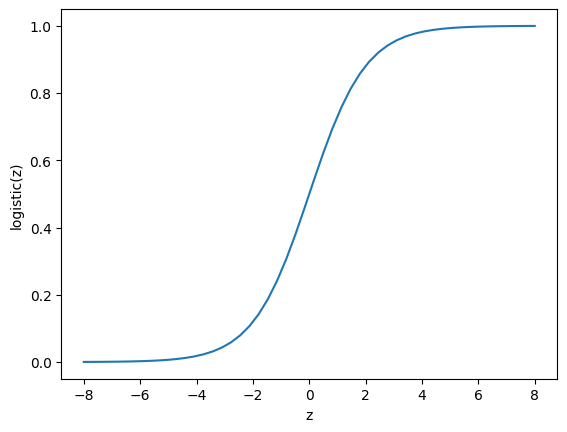

In [ ]:
#Graph of Logistic Function
z = np.linspace(-8, 8)
plt.plot(z, 1 / (1 + np.exp(-z)))
plt.xlabel("z")
plt.ylabel("logistic(z)")

In [ ]:
iris = pd.read_csv("iris.csv")
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [ ]:
#converting names of flowers into numbers
df = iris.query("species == ('setosa', 'versicolor')")
y_0 = pd.Categorical(df["species"]).codes
x_n = "sepal_length"
x_0 = df[x_n].values
#Centering the data (subtracting mean from each point)
x_c = x_0 - x_0.mean()

In [ ]:
#Using Logistic model
with pm.Model() as model_lrs:
    α = pm.Normal("α", mu=0, sigma=1)
    β = pm.Normal("β", mu=0, sigma=5)
    μ = α + x_c * β
    θ = pm.Deterministic("θ", pm.math.sigmoid(μ))
    bd = pm.Deterministic("bd", -α / β)
    yl = pm.Bernoulli("yl", p=θ, observed=y_0)
    idata_lrs = pm.sample(random_seed=123)

Output()

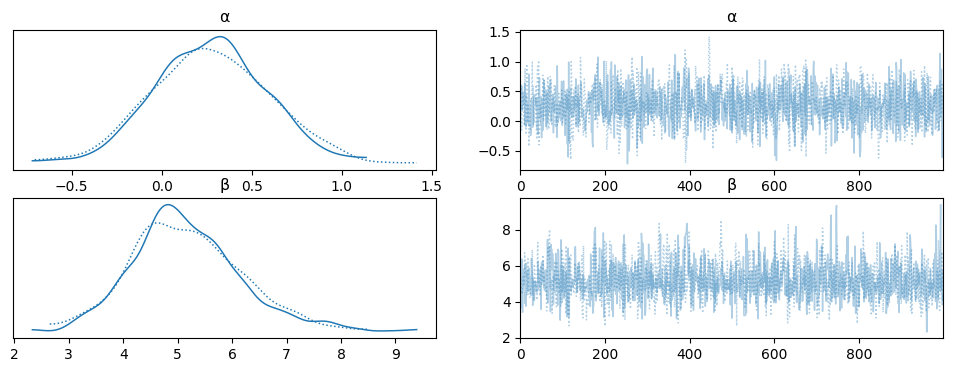

In [ ]:
az.plot_trace(idata_lrs, var_names=["~bd", "~θ"]);

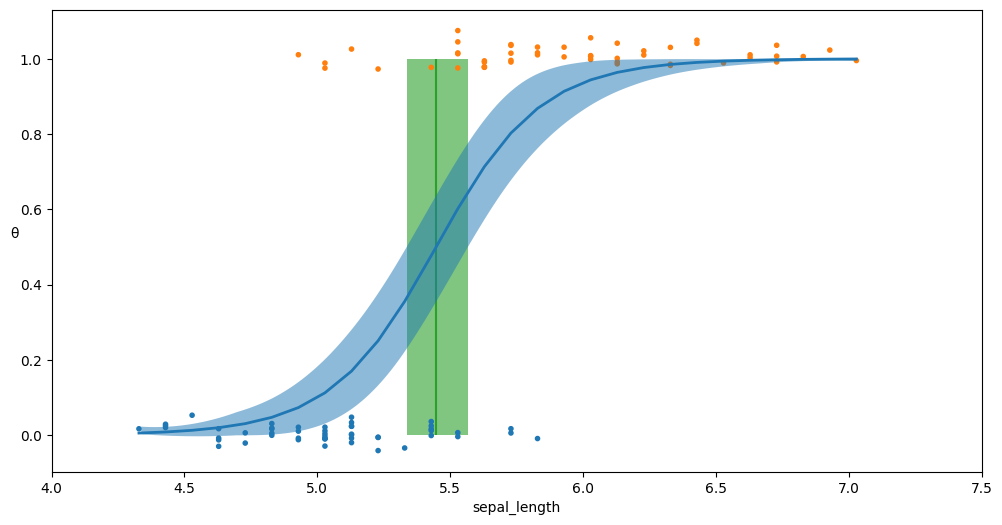

In [ ]:
#plotting everything
posterior = idata_lrs.posterior
#mean of theta for all posteriors
theta = posterior["θ"].mean(("chain", "draw"))
#creating an index for x-axis (ascending order)
idx = np.argsort(x_c)

_, ax = plt.subplots(figsize=(12, 6))

#Plot of theta_mean vs x_c
ax.plot(x_c[idx], theta[idx], color="C0", lw=2)
#
ax.vlines(posterior["bd"].mean(("chain", "draw")), 0, 1, color="C2", zorder=0)
#HDI interval for bd (boundary decision)
bd_hdi = az.hdi(posterior["bd"])
ax.fill_betweenx([0, 1], bd_hdi["bd"][0], bd_hdi["bd"][1], color="C2", alpha=0.6, lw=0)
#scatter plot of all points
ax.scatter(x_c, np.random.normal(y_0, 0.02), marker=".", color=[f"C{x}" for x in y_0])
#Plot HDI interval for theta
az.plot_hdi(x_c, posterior["θ"], color="C0", ax=ax, fill_kwargs={"lw": 0})
ax.set_xlabel(x_n)
ax.set_ylabel("θ", rotation=0)
#use original scale for xticks
locs, _ = plt.xticks()
ax.set_xticks(locs, np.round(locs + x_0.mean(), 1))

<ipython-input-21-98daa69cb65b>:3: RuntimeWarning: divide by zero encountered in divide
  odds = probability / (1 - probability)


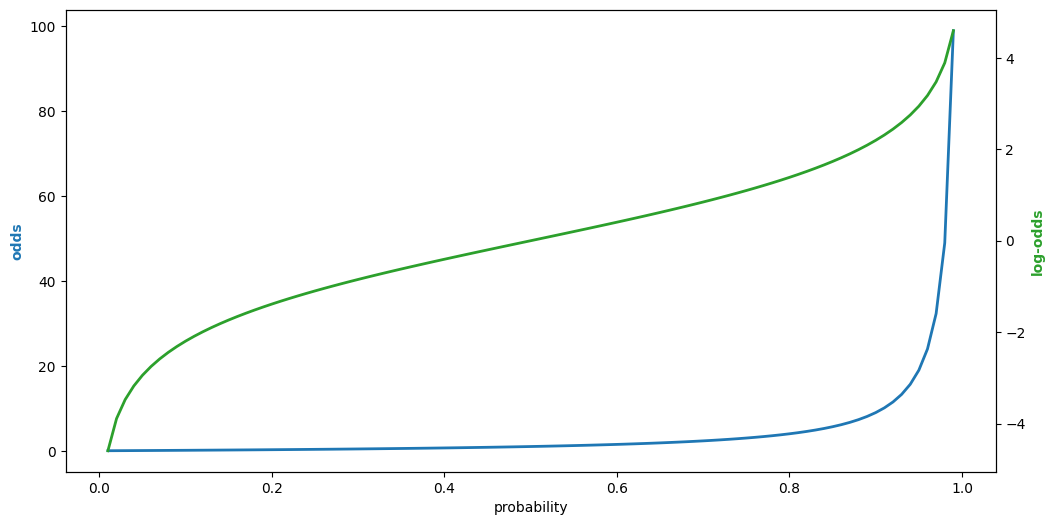

In [ ]:
#Comparing probs, odds, log-odds scales
probability = np.linspace(0.01, 1, 100)
odds = probability / (1 - probability)
_, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()
ax1.plot(probability, odds, "C0", lw=2)
ax2.plot(probability, np.log(odds), "C2", lw=2)
ax1.set_xlabel("probability")
ax1.set_ylabel("odds", color="C0", fontweight="bold")
ax2.set_ylabel("log-odds", color="C2", fontweight="bold")
ax1.grid(False)
ax2.grid(False)

## Variable Variance

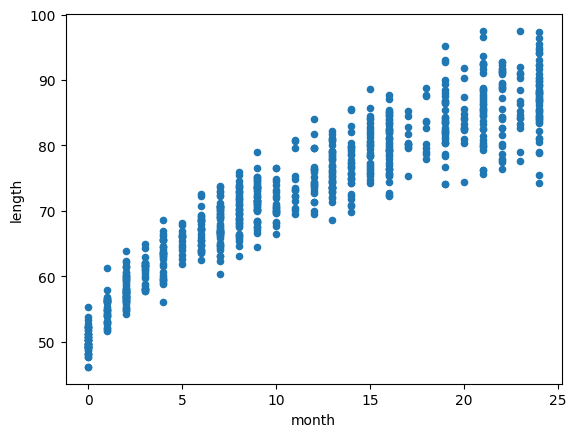

In [ ]:
data = pd.read_csv("babies.csv")
data.plot.scatter("month", "length");

In [ ]:
data.head()

,month,length
0,0,49.192857
1,0,51.221429
2,0,51.221429
3,0,52.742857
4,0,48.178571


In [ ]:
#Modelling with modified GLM
with pm.Model() as model_vv:
    x_shared = pm.MutableData("x_shared", data.month.values.astype(float))
    α = pm.Normal("α", sigma=10)
    β = pm.Normal("β", sigma=10)
    γ = pm.HalfNormal("γ", sigma=10)
    δ = pm.HalfNormal("δ", sigma=10)

    μ = pm.Deterministic("μ", α + β * x_shared**0.5)
    σ = pm.Deterministic("σ", γ + δ * x_shared)

    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=data.length)

    idata_vv = pm.sample(random_seed=123)

/usr/local/lib/python3.11/dist-packages/pymc/data.py:265: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


Output()

Text(0, 0.5, '$\\bar \\sigma$')

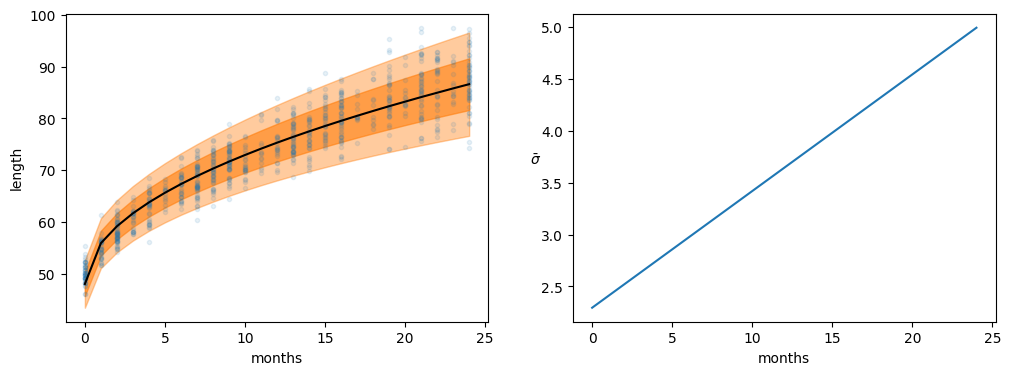

In [ ]:
#Plotting everything
_, axes = plt.subplots(1, 2, figsize=(12, 4))

#scatter plot
axes[0].plot(data.month, data.length, "C0.", alpha=0.1)

#extracting data
posterior = az.extract(idata_vv)

#finding mean of mean and std dev
μ_m = posterior["μ"].mean("sample").values
σ_m = posterior["σ"].mean("sample").values

#plot of shaded region with 1 and 2 std dev
axes[0].plot(data.month, μ_m, c="k")
axes[0].fill_between(data.month, μ_m + 1 * σ_m, μ_m - 1 * σ_m, alpha=0.6, color="C1")
axes[0].fill_between(data.month, μ_m + 2 * σ_m, μ_m - 2 * σ_m, alpha=0.4, color="C1")

axes[0].set_xlabel("months")
axes[0].set_ylabel("length")

#plotting variance as a function of month
axes[1].plot(data.month, σ_m)
axes[1].set_xlabel("months")
axes[1].set_ylabel(r"$\bar \sigma$", rotation=0)


In [ ]:
#Trying to find the distributin of heights for a certain months
with model_vv:
    pm.set_data({"x_shared": [0.5]})
    ppc = pm.sample_posterior_predictive(idata_vv, random_seed=123)
    y_ppc = ppc.posterior_predictive["y_pred"].stack(sample=("chain", "draw"))

Output()

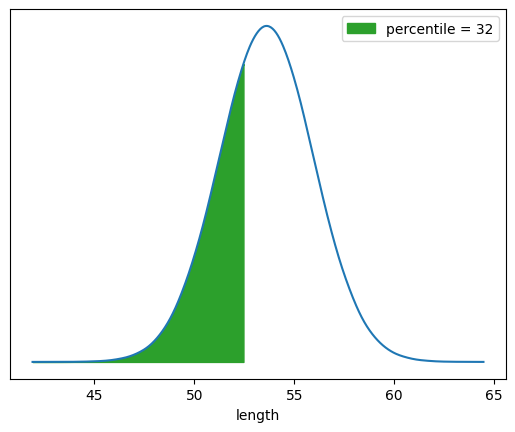

In [ ]:
ref = 52.5
grid, pdf = az.stats.density_utils._kde_linear(y_ppc.values)
plt.plot(grid, pdf)
percentile = int((y_ppc <= ref).mean() * 100)
plt.fill_between(
    grid[grid < ref],
    pdf[grid < ref],
    label="percentile = {:2d}".format(percentile),
    color="C2",
)
plt.xlabel("length")
plt.yticks([])
plt.legend()

## Hierarchical linear regression

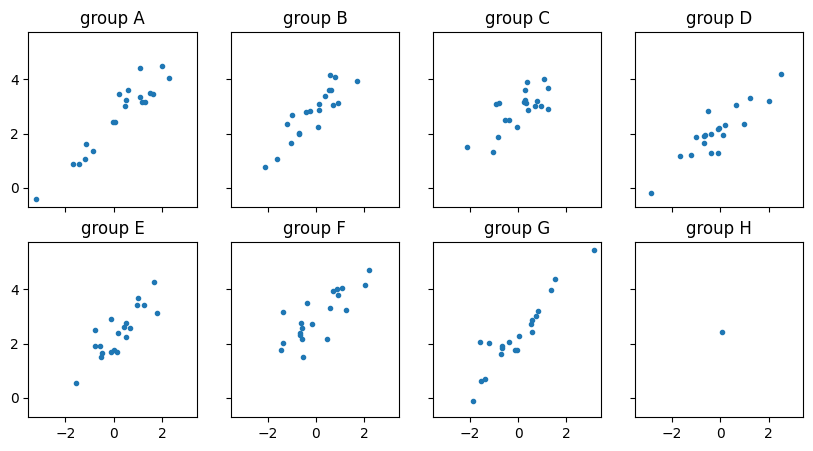

In [ ]:
#Creating a synthetic data
N = 20
groups = ["A", "B", "C", "D", "E", "F", "G", "H"]
M = len(groups)
idx = np.repeat(range(M - 1), N)
idx = np.append(idx, 7)
np.random.seed(314)
alpha_real = np.random.normal(2.5, 0.5, size=M)
beta_real = np.random.beta(6, 1, size=M)
eps_real = np.random.normal(0, 0.5, size=len(idx))
y_m = np.zeros(len(idx))
x_m = np.random.normal(0, 1, len(idx))
y_m = alpha_real[idx] + beta_real[idx] * x_m + eps_real
_, ax = plt.subplots(2, 4, figsize=(10, 5), sharex=True, sharey=True)
ax = np.ravel(ax)
j, k = 0, N
for i, g in enumerate(groups):
    ax[i].scatter(x_m[j:k], y_m[j:k], marker=".")
    ax[i].set_title(f"group {g}")

    j += N
    k += N

In [ ]:
#Using Non-hierarchical Linear regression
coords = {"group": groups}

with pm.Model(coords=coords) as unpooled_model:
    α = pm.Normal("α", mu=0, sigma=10, dims="group")
    β = pm.Normal("β", mu=0, sigma=10, dims="group")
    σ = pm.HalfNormal("σ", 5)
    _ = pm.Normal("y_pred", mu=α[idx] + β[idx] * x_m, sigma=σ, observed=y_m)
    idata_up = pm.sample(random_seed=123)

Output()

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

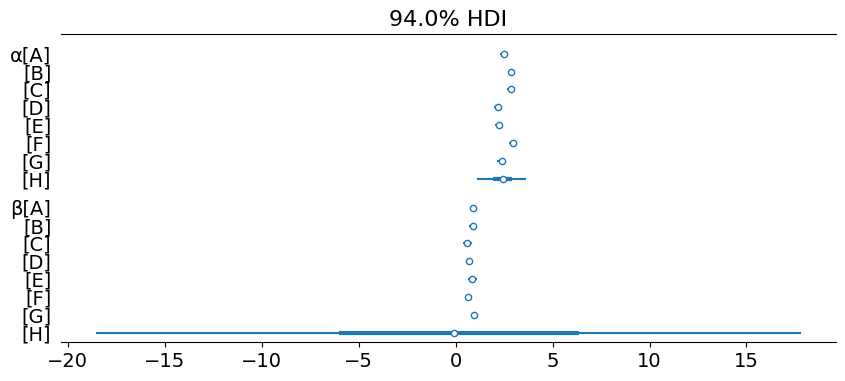

In [ ]:
#Plotting alpha and beta
az.plot_forest(idata_up, var_names=["α", "β"], combined=True, figsize=(10, 4))

In [ ]:
#Hierarchical Linear Regression Model
with pm.Model(coords=coords) as hierarchical_centered:
    # hyper-priors
    α_μ = pm.Normal("α_μ", mu=y_m.mean(), sigma=1)
    α_σ = pm.HalfNormal("α_σ", 5)
    β_μ = pm.Normal("β_μ", mu=0, sigma=1)
    β_σ = pm.HalfNormal("β_σ", sigma=5)

    # priors
    α = pm.Normal("α", mu=α_μ, sigma=α_σ, dims="group")
    β = pm.Normal("β", mu=β_μ, sigma=β_σ, dims="group")
    σ = pm.HalfNormal("σ", 5)
    _ = pm.Normal("y_pred", mu=α[idx] + β[idx] * x_m, sigma=σ, observed=y_m)

    idata_cen = pm.sample(random_seed=123)

Output()

ERROR:pymc.stats.convergence:There were 42 divergences after tuning. Increase `target_accept` or reparameterize.


In [ ]:
#Non-centered Hierarchical Linear regression Model
with pm.Model(coords=coords) as hierarchical_non_centered:
    # hyper-priors
    α_μ = pm.Normal("α_μ", mu=y_m.mean(), sigma=1)
    α_σ = pm.HalfNormal("α_σ", 5)
    β_μ = pm.Normal("β_μ", mu=0, sigma=1)
    β_σ = pm.HalfNormal("β_σ", sigma=5)

    # priors
    α = pm.Normal("α", mu=α_μ, sigma=α_σ, dims="group")

    β_offset = pm.Normal("β_offset", mu=0, sigma=1, dims="group")
    β = pm.Deterministic("β", β_μ + β_offset * β_σ, dims="group")

    σ = pm.HalfNormal("σ", 5)
    _ = pm.Normal("y_pred", mu=α[idx] + β[idx] * x_m, sigma=σ, observed=y_m)

    idata_ncen = pm.sample(random_seed=123, target_accept=0.9)

Output()

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

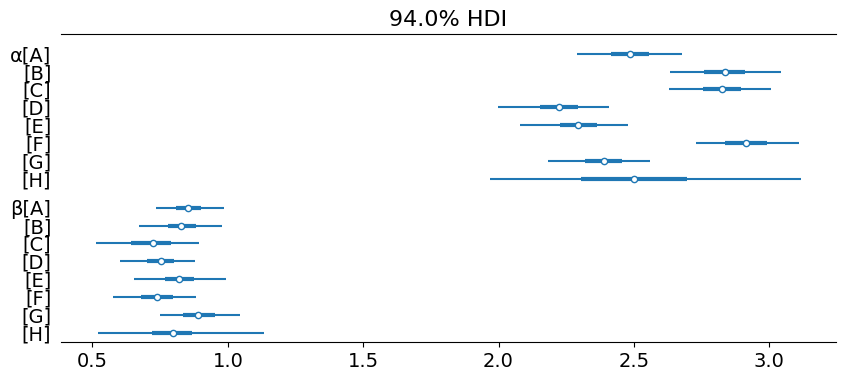

In [ ]:
az.plot_forest(idata_ncen, var_names=["α", "β"], combined=True, figsize=(10, 4))

/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/usr/local/lib/python3.11/dist-packages/arviz/plots/

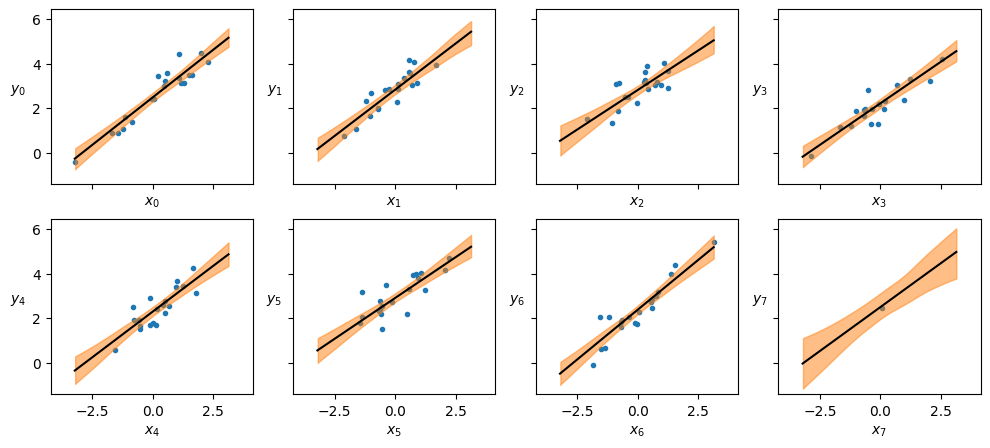

In [ ]:
#Line plots for all groups
_, ax = plt.subplots(2, 4, figsize=(12, 5), sharex=True, sharey=True)
ax = np.ravel(ax)
j, k = 0, N
x_range = np.linspace(x_m.min(), x_m.max(), 10)
posterior = az.extract(idata_ncen)

for i, g in enumerate(groups):
    ax[i].scatter(x_m[j:k], y_m[j:k], marker=".")
    ax[i].set_xlabel("$x_{}$".format(i))
    ax[i].set_ylabel("$y_{}$".format(i), labelpad=10, rotation=0)
    alfas = posterior["α"].sel(group=g)
    betas = posterior["β"].sel(group=g)
    alfa_m = alfas.mean("sample").item()
    beta_m = betas.mean("sample").item()
    ax[i].plot(x_range, alfa_m + beta_m * x_range, c="k")
    az.plot_hdi(x_range, alfas + betas * xr.DataArray(x_range).transpose(), ax=ax[i])
    plt.xlim(x_m.min() - 1, x_m.max() + 1)
    plt.ylim(y_m.min() - 1, y_m.max() + 1)
    j += N
    k += N

## Multiple linear regression

In [ ]:
bikes.head()

,rented,hour,temperature,humidity,windspeed,weekday
0,16,0,3.28,0.81,0.0000,6
1,3,5,-0.48,0.47,0.2836,1
2,115,9,2.34,0.37,0.3284,3
3,73,13,1.40,0.37,0.2836,5
4,82,15,2.34,0.35,0.3582,0


In [ ]:
#Multiple Linear Regression Model: One dependent variable with multiple independent variables
with pm.Model() as model_mlb:
    α = pm.Normal("α", mu=0, sigma=1)
    β0 = pm.Normal("β0", mu=0, sigma=10)
    β1 = pm.Normal("β1", mu=0, sigma=10)
    σ = pm.HalfNormal("σ", 10)
    μ = pm.Deterministic("μ", pm.math.exp(α + β0 * bikes.temperature + β1 * bikes.hour))
    _ = pm.NegativeBinomial("y_pred", mu=μ, alpha=σ, observed=bikes.rented)

    idata_mlb = pm.sample(random_seed=123)


Output()

In [ ]:
#Comparison between simple linear regression and multiple linear regression
idata_neg.posterior["β0_scaled"] = idata_neg.posterior["β"] * bikes.temperature.std()

idata_mlb.posterior["β0_scaled"] = idata_mlb.posterior["β0"] * bikes.temperature.std()
idata_mlb.posterior["β1_scaled"] = idata_mlb.posterior["β1"] * bikes.hour.std()

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

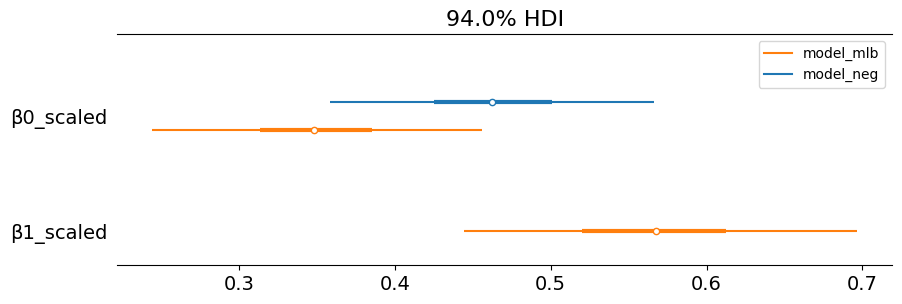

In [ ]:
az.plot_forest([idata_neg, idata_mlb], model_names=["model_neg", "model_mlb"],
var_names=["β0_scaled", "β1_scaled"], figsize=(10, 3), combined=True)